In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mcpdf.nnpdf import data, defaults, theory

%matplotlib inline

In [2]:
# datasets
datasets_list = [
    {'dataset': 'HERACOMBNCEM', 'frac': 0.75}, 
    {'dataset': 'HERACOMBNCEP460', 'frac': 0.75}, 
    {'dataset': 'HERACOMBNCEP575', 'frac': 0.75}, 
    {'dataset': 'HERACOMBNCEP820', 'frac': 0.75}, 
    {'dataset': 'HERACOMBNCEP920', 'frac': 0.75}, 
    {'dataset': 'HERACOMBCCEM', 'frac': 0.75}, 
    {'dataset': 'HERACOMBCCEP', 'frac': 0.75},
    {'dataset': 'CHORUSNUPb_dw_ite', 'frac': 0.75}, 
    {'dataset': 'CHORUSNBPb_dw_ite', 'frac': 0.75}, 
    {'dataset': 'NTVNUDMNFe_dw_ite', 'frac': 0.75}, 
    {'dataset': 'NTVNBDMNFe_dw_ite', 'frac': 0.75}]

ndatasets = len(datasets_list)

# load data and covmat for all the dataset
y = data.values(fit=defaults.BASELINE_PDF, dataset_inputs=datasets_list)
cov = data.covmat(fit=defaults.BASELINE_PDF, dataset_inputs=datasets_list)

In [3]:
y.shape

(2053,)

In [4]:
cov.shape

(2053, 2053)

In [5]:
# load FK tables
fks = theory.theory(dataset_inputs=[ds['dataset'] for ds in datasets_list])
fk_bare = np.concatenate([fk.elements[0].table for fk in fks], axis=0)
fk_bare.shape


-- Reading COMMONDATA for Dataset: CHORUSNUPb_dw_ite
nData: 607 nSys: 1014
-- COMMONDATA Files for CHORUSNUPb_dw_ite successfully read.


-- Reading COMMONDATA for Dataset: CHORUSNBPb_dw_ite
nData: 607 nSys: 114
-- COMMONDATA Files for CHORUSNBPb_dw_ite successfully read.


-- Reading COMMONDATA for Dataset: NTVNUDMNFe_dw_ite
nData: 45 nSys: 1003
-- COMMONDATA Files for NTVNUDMNFe_dw_ite successfully read.


-- Reading COMMONDATA for Dataset: NTVNBDMNFe_dw_ite
nData: 45 nSys: 103
-- COMMONDATA Files for NTVNBDMNFe_dw_ite successfully read.


-- Reading COMMONDATA for Dataset: HERACOMBNCEM
nData: 159 nSys: 170
-- COMMONDATA Files for HERACOMBNCEM successfully read.


-- Reading COMMONDATA for Dataset: HERACOMBNCEP460
nData: 209 nSys: 170
-- COMMONDATA Files for HERACOMBNCEP460 successfully read.


-- Reading COMMONDATA for Dataset: HERACOMBNCEP575
nData: 260 nSys: 170
-- COMMONDATA Files for HERACOMBNCEP575 successfully read.


-- Reading COMMONDATA for Dataset: HERACOMBNCEP820
nData: 

(2053, 9, 50)

In [6]:
# reshape FK table as a matrix
ndata, nbasis, nx = fk_bare.shape
fk = fk_bare.reshape(ndata,nbasis*nx)
fk.shape

(2053, 450)

In [7]:
def distinfo(values):
    print(f"   max = {max(values)}",
          f"   min = {min(values)}",
          f"absmin = {min(abs(values))}",
          sep = "\n")

    sns.boxenplot(x=values, scale="exponential")
    plt.xscale("log")

   max = 308.39648487355925
   min = 1.8638700388327588e-06
absmin = 1.8638700388327588e-06


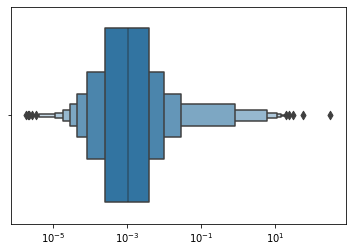

In [8]:
# diagonalize experimental covmat and check its eigenvalues
l, u = np.linalg.eig(cov)
distinfo(l)

In [9]:
#inv_cov = u @ np.diag(1./l) @ u.T 
#inv_cov@cov

In [10]:
# compute inverse of the posterior covmat according to Eq.46
v = u.T@fk
posterior_cov_inverse = v.T @ np.diag(1./l) @ v

In [11]:
posterior_cov_inverse.shape

(450, 450)

In [12]:
# add a gaussian prior proportional to regularize
_, N = posterior_cov_inverse.shape
posterior_cov_inverse_prior = posterior_cov_inverse + 0.001*np.identity(N)

   max = 290362387.0521207
   min = -5.200987252054414e-09
absmin = 6.259910166570457e-14


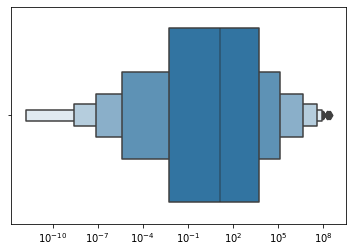

In [13]:
# check eigenvalues without prior
ll, uu = np.linalg.eig(posterior_cov_inverse)
distinfo(np.real(ll))

   max = 290362387.05312204
   min = 0.0009999923879911324
absmin = 0.0009999923879911324


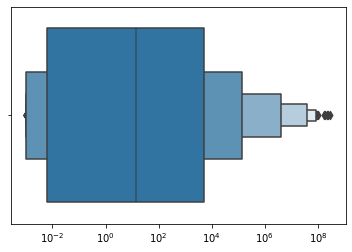

In [14]:
# check eigenvalues with prior
llp, uup = np.linalg.eig(posterior_cov_inverse_prior)
llp = np.real(llp)
uup = np.real(uup)
distinfo(llp)

In [15]:
# posterior covmat
cov_posterior = uup @ np.diag(1./llp) @ uup.T

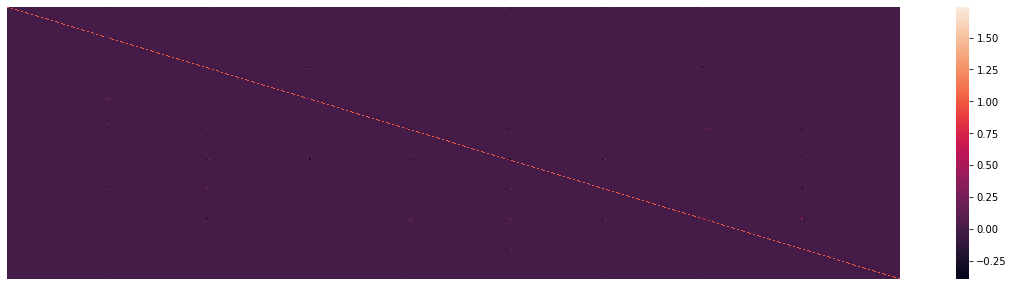

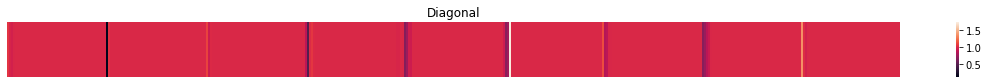

In [16]:
id_test = posterior_cov_inverse_prior @ cov_posterior
plt.figure(figsize=(20,5))
sns.heatmap(id_test, xticklabels=False, yticklabels=False)
plt.figure(figsize=(20, 1))
plt.title("Diagonal")
sns.heatmap(np.diag(id_test)[np.newaxis,:], xticklabels=False, yticklabels=False);

In [17]:
# compute central value posterior, Eq. 47
v1 = u.T@y
w = uup.T@fk.T@ u
cv_posterior = uup @ np.diag(1./llp) @ w @ np.diag(1./l) @ v1

In [18]:
cv_posterior.shape

(450,)

In [19]:
# draw samples
samples=np.random.multivariate_normal(cv_posterior, cov_posterior, size=1000)

In [20]:
samples.shape

(1000, 450)

In [21]:
f = np.array([samples[:,i*50:(i+1)*50] for i in range(0,9)])
flavour_cv = f.mean(axis=1)
flavour_std = f.std(axis=1)
    
flavour_labels=['Sigma','g','V','V3','V8','V15','T3','T8','T15']

In [22]:
x = np.array([
2.9699999989970886e-05,
4.1246302562114121e-05,
5.7279854290892427e-05,
7.9543107354176351e-05,
1.1045380151089824e-04,
1.5336544212678162e-04,
2.1292711419771039e-04,
2.9557946342023174e-04,
4.1023635832702205e-04,
5.6921788919482173e-04,
7.8952001737071158e-04,
1.0945283774603655e-03,
1.5163052361650959e-03,
2.0985919006607802e-03,
2.9006588501226953e-03,
4.0020755222241709e-03,
5.5083182403814438e-03,
7.5568314649709480e-03,
1.0322652614357851e-02,
1.4022011128953883e-02,
1.8911583033933310e-02,
2.5280751342878608e-02,
3.3434951223099259e-02,
4.3670479005884652e-02,
5.6244653828324422e-02,
7.1348265292604018e-02,
8.9087633304453406e-02,
1.0948053859041228e-01,
1.3246538983220960e-01,
1.5791909766096124e-01,
1.8567792651252230e-01,
2.1555676356233966e-01,
2.4736436150447358e-01,
2.8091396862547191e-01,
3.1602987267868177e-01,
3.5255081809432581e-01,
3.9033126797342838e-01,
4.2924130793198417e-01,
4.6916577293070166e-01,
5.1000298771219632e-01,
5.5166336656838788e-01,
5.9406801715516011e-01,
6.3714742681882575e-01,
6.8084026849030499e-01,
7.2509233853930255e-01,
7.6985562506376237e-01,
8.1508749786096646e-01,
8.6075000810050684e-01,
9.0680928480266942e-01,
9.5323501557082535e-01,
])

In [23]:
x.shape

(50,)

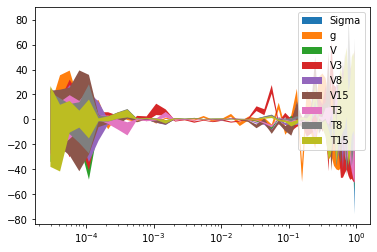

In [24]:
for i in range(0,9):
    plt.fill_between(x, flavour_cv[i]-flavour_std[i], flavour_cv[i]+flavour_std[i], label=flavour_labels[i])
plt.xscale('log')
plt.legend()